### **Motivation**

Few days ago, I was reading machine learning for asset managers by Marcos Lopez de Prado. He answers the question "why don't you discuss a wide range of ML algorithm?" and then take an example to explain why once we have engineered the features, choosing the algorithm play a second role.

#### **Here is the extract of this passage:**
Compare an algorithm that forecasted a change of 1, but received a realized change of 3, with another algorithm that forecasted a change of -1, but received a realized change of 1. In both cases, the forecast error is 2. In many industrial applications, we would be indifferent between both errors. That is not the case in finance. In the first instance, an investor makes one-third of the predicted profit, whereas in the second instance the investor suffers a loss equal to the predicted profit. Failing to predict the size is an opportunity loss, but failing to predict the sign is an actual loss. 


After reading, I decided to predict the sign of the movement n days ahead of us.
I found a research paper that helped me a lot on finding relevant features. Here is the link: [paper](https://arxiv.org/pdf/1605.00003.pdf).


### **Libraries**

In [ ]:
!pip install yfinance
import yfinance as yf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV


     |████████████████████████████████| 5.5MB 4.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=367ba06415536eac42b5df4cd03d16a96cf1e6f7185a18befa78f2b5eebc362e
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


### **Data collection**

In [ ]:
ticker = yf.Ticker('WMT')
# get historical market data over the last 5 years
hist = ticker.history(start="2018-10-01", end="2020-10-01")

In [ ]:
dataset = hist[['Open','Close', 'Low', 'High','Volume']]

In [ ]:
dataset

,Open,Close,Low,High,Volume
Date,,,,,
2018-10-01,90.737977,90.843834,90.497395,91.094041,4994300
2018-10-02,90.391540,91.565582,90.314552,92.008253,7754600
2018-10-03,91.902398,90.526268,90.497399,91.940892,6327400
2018-10-04,90.526247,90.660973,89.689019,90.940049,6045300
2018-10-05,90.324167,89.794884,89.390707,90.641738,6693400
...,...,...,...,...,...
2020-09-24,135.729996,136.699997,135.070007,137.789993,9817700
2020-09-25,136.520004,137.270004,135.960007,137.539993,7539600
2020-09-28,137.160004,137.250000,136.720001,138.050003,7065700


### **Exponential Smoothing**

The time series historical stock data is first exponentially smoothed. Exponential smoothing applies more weightage to the recent observation and exponentially decreasing weights to past observations. The exponentially smoothed statistic of a series Y can be recursively calculated as:
 
 $S_{t}=α*y_{t} + (1-α)s_{t-1}$, for $t>0$.

α is the smoothing factor and 0 < α < 1. Larger values of α reduce the level of smoothing.
When α = 1, the smoothed statistic becomes equal to the actual observation. 

This smoothing removes random variation or noise from the historical data allowing the model to easily identify long term price trend in the stock price behavior. 

In [ ]:
smoothed_dataset = dataset.ewm(alpha=0.3, adjust=False).mean()

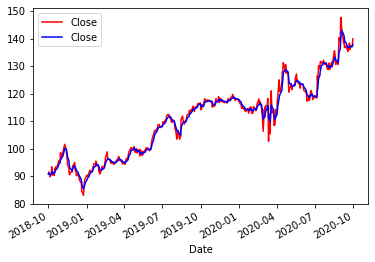

In [ ]:
ax = plt.gca()
dataset.plot(y=['Close'],kind ='line',color='red', ax=ax )
smoothed_dataset.plot(y=['Close'],kind ='line',color='blue', ax=ax )

### **Features Extraction**
Technical indicators are calculated from the exponentially smoothed time series data which will be feature matrix use later in the notebook. 

#### **RSI**

RSI is a popular momentum indicator which determines whether the stock is overbought or oversold. A stock is said to be overbought when the demand unjustifiably pushes the price upwards. This condition is generallyt interpreted as a sign that the stock is overvalued and the price is likely to go down. A stock is said to be oversold when the price goes down sharply to a level below its true value. This is a result caused due to panic selling. RSI ranges from 0 to 100 and generally, when RSI is above 70, it may indicate that the stock is overbought and when RSI is below 30, it may indicate the stock is oversold.

In [ ]:
def compute_RSI(dataset):
  delta = dataset.Close.diff()
  window = 14
  up_days = delta.copy()
  up_days[delta<=0]=0.0
  down_days = abs(delta.copy())
  down_days[delta>0]=0.0
  RS_up = up_days.rolling(window).mean()
  RS_down = down_days.rolling(window).mean()
  rsi= 100-100/(1+RS_up/RS_down)
  dataset['RSI'] = rsi


#### **Stochastic Oscillator**
Stochastic Oscillator follows the speed or the momentum of the price. As a rule, momentum changes before the price changes. It measures the level of the closing price relative to low-high range over a period of time.

*   C = Current Closing Price
*   L14 = Lowest Low over the past 14 days 
*   H14 = Highest High over the past 14 days


The formula for calculating Stochastic Oscillator is:
$K=100∗ \frac{(C−L14)}{(H14 − L14)}$



In [ ]:
def compute_stochastic_oscialtor(dataset):
  window = 14
  highest_high = smoothed_dataset['High'].rolling(window).max()
  lowest_low = dataset['Low'].rolling(window).min()
  K = 100 * (dataset['Close']-lowest_low)/highest_high-lowest_low
  dataset['K'] = K


#### **Moving Average Convergence Divergence and signal line**

When the MACD goes below the SingalLine, it indicates a sell signal. When it goes above the SignalLine, it indicates a buy signal.

* MACD = Moving Average Convergence 
Divergence 
* C = Closing Price series
* ${EMA}_{n}$ = n day Exponential Moving Average

$MACD = {EMA}_{12}(C) − {EMA}_{26}(C)$

$SignalLine = {EMA}_{9}(MACD) $


In [ ]:

def compute_MACD_SL(dataset):
  EMA12 = pd.Series.ewm(dataset['Close'],span=12,adjust = False).mean()
  EMA26 = pd.Series.ewm(dataset['Close'],span=26, adjust=False,).mean()
  MACD = EMA12-EMA26
  dataset['MACD'] = MACD
  SL = pd.Series.ewm(MACD, span=9, adjust=False).mean()
  dataset['SL'] = SL


#### **Price Rate of change** 

It measures the most recent change in price with respect to the price in n days ago.

* PROC(t) = Price Rate of Change at time t
* C(t) = Closing price at time t

$PROC(t) = \frac{C(t) − C(t − n)}{C(t−n)}$

In [ ]:
def compute_PROC(dataset, n):
  N = dataset['Close'].diff(n)
  D = dataset['Close'].shift(n)
  PROC = N/D
  dataset['PROC'] = PROC

#### **On Balance VOlume**

This technical indicator is used to find buying and selling trends of a stock. 

In [ ]:
def compute_OBV(dataset):
  OBV = (dataset['Volume'] * (~dataset['Close'].diff().le(0) * 2 -1)).cumsum()
  dataset['OBV'] = OBV

#### **Adding the movement :**
The target to be predicted in the ith day is calculated as follows:
$target_{i} = Sign({close}_{i+d} − {close}_{i})$, where d is the number of days after which the prediction is to be made.

In [ ]:
def add_movement(dataset, d):
  dataset['Movement'] = dataset['Close'].pct_change(d).apply(lambda x: 1 if x > 0 else -1 if x <= 0 else np.nan)

### **Building the features dataframe**


In [ ]:
features = smoothed_dataset
compute_RSI(features)
compute_stochastic_oscialtor(features)
compute_MACD_SL(features)
compute_PROC(features, 12)
compute_OBV(features)
add_movement(features, 10)

### **Perform Random Forest classification**





In [ ]:
def perform_rfr(features):
  # Creating test and train set 
  X = features.iloc[:, :-1]
  y = features.iloc[:, -1]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  # Regression : estimators = trees
  classifier = RandomForestClassifier(n_estimators = 100, random_state = 0, max_features='sqrt', max_depth=20, min_samples_leaf = 4,min_samples_split = 5, bootstrap=False)
  classifier.fit(X_train, y_train)

  # prediction
  y_pred = classifier.predict(X_test)
  regression_score = r2_score(y_test, y_pred)

  # Get the confusion matrix
  mconfusion = confusion_matrix(y_pred, y_test)

  return regression_score, mconfusion, X_train, X_test,y_train, y_pred, y_test, classifier


In [ ]:
features = features.iloc[30:,:] # dump the first mo,th to get rid of the nan values 

In [ ]:
score, confusion, X_train, X_test, y_train, y_pred, y_test, classifier = perform_rfr(features)

In [ ]:
def display_Confusion_matrix(cf_matrix):
  plt.figure()
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = ['-1','1'], yticklabels=['-1','1'], cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

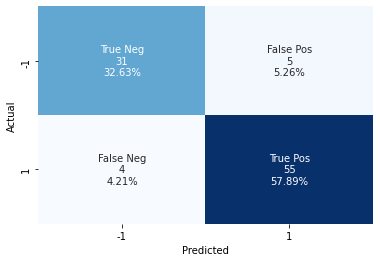

In [ ]:
display_Confusion_matrix(confusion)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.88      0.95      0.91        44
         1.0       0.96      0.88      0.92        51

    accuracy                           0.92        95
   macro avg       0.92      0.92      0.92        95
weighted avg       0.92      0.92      0.92        95



### **Looking for ways of improvements**

One easy way to improve the model would be to feed more data. Most likely, it would give more details about how things work together to the classifer.

#### **Feature Selection**

In [ ]:
def display_features_relevance(regressor,features):
  fig = plt.figure()
  Relevances = pd.DataFrame({'Relevance':classifier.feature_importances_*100}, index=features.columns.values[:-1])
  Relevances.sort_values('Relevance', axis=0, ascending=True).plot(kind='barh', color='r', )
  plt.xlabel('Variable Relevance')
  plt.gca().legend_ = None
  plt.show()

In [ ]:
def display_correlation_matrix(features):
  correlations = features.drop(['Direction'], axis =1).corr()
  # plot correlation matrix
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(correlations, vmin=-1, vmax=1)
  fig.colorbar(cax)
  ticks = np.arange(0,12,1)
  ax.set_xticks(ticks)
  ax.set_yticks(ticks)
  index=features.columns.values[:-1]
  ax.set_xticklabels(index)
  plt.xticks(rotation =45)
  ax.set_yticklabels(index)
  plt.show()


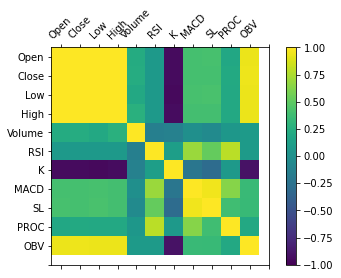

In [ ]:
display_correlation_matrix(features)

Unsurprisingly, there is a high correlation between the open, close, low and high features. However, we find out that those features have a high correlation with the on balance volume as well. It is interesting since the frist features don't have a high correlation with the volume feature. Also, we can notice that the stochastic oscilator (k) is the most singular feature.

<Figure size 432x288 with 0 Axes>

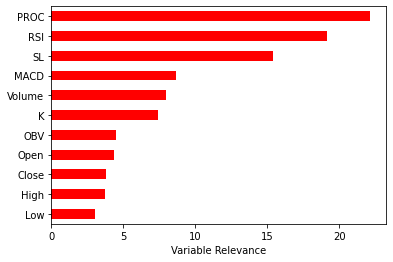

In [ ]:
display_features_relevance(regressor, features)

Thanks to this graph I got rid of the Wiliams indicator feature. The relevance was super high compare to the rest which I didn't like for some reasons. I also found out that it was can of a duplicate of the stochastic oscialtor feature.

#### **Looking for best parameters** 
At first, I used the regressor with the basic parameters. By doing what follows, I tried to make it better. I gain a little bit in accuracy but it is marginal!

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 100}

Well, it didn't really work when I used these parameters ... I kept everything except bootstrap = false though.

#### **Other Classifcation methods**

I am not going to adress this but we could have tried Support Vector or K-Nearest Neighboors classifications.

### **Conclusion**

Developing a trading strategy from that is possible. For instance, it could be interesting to look if there is successive days ahead (or just a majority) with the same movement , and,  then decide to go long or short for this period.
I believe that doing everyday trading by forecasting one day ahead generates too much cost.

